# Linear Regression in statsmodels (Practice)

**Task:** Run a linear regression with statsmodels predict the price of a car.

**Data:** https://www.kaggle.com/datasets/hellbuoy/car-price-prediction

**Steps to perform:**

- Perform initial preprocessing of data
- Perform preprocessing for statsmodels
- Run the model in statsmodels and produce a results summary
- Evaluate the model on the test set

# 1. Preliminary Steps

In [45]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score, mean_squared_error
np.random.seed(321)
import statsmodels.api as sm

In [20]:
# load data
df = pd.read_csv('Data/CarPrice_Assignment.csv')

# check
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


**Target:** The model we build will be used to predict the price of the cars.

In [21]:
# check for null values
df.isna().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

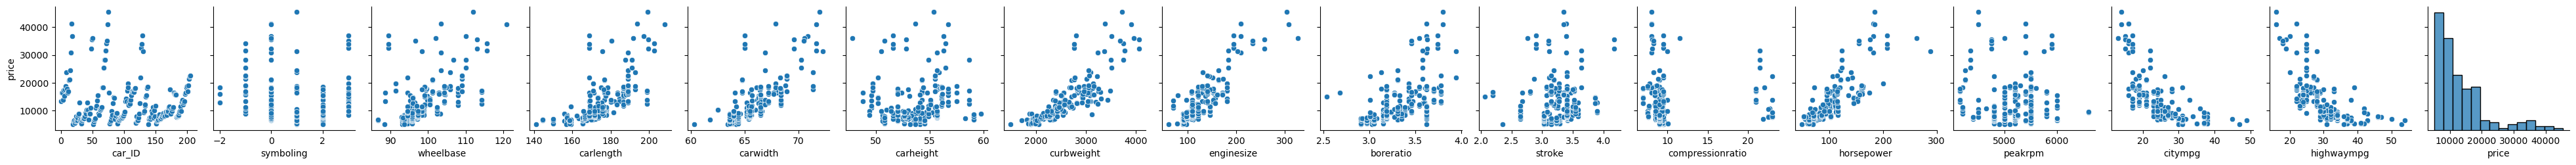

In [22]:
# quick eda
sns.pairplot(df, y_vars = 'price');

In [23]:
# renaming categorical variable 'symboling' according to data dictionary
symboling_map = {-3: "safest",
                -2: "safer",
                -1: "safe",
                0: "neutral",
                1: "risky",
                2: "riskier",
                3: "riskiest"}

df['symboling'] = df['symboling'].replace(symboling_map)

# check
df['symboling'].value_counts()

neutral     67
risky       54
riskier     32
riskiest    27
safe        22
safer        3
Name: symboling, dtype: int64

In [24]:
# make X and y
y = df['price'].copy()

# for X, will drop 'car_ID' since it is unique to each observation
# will also drop 'CarName'
X = df.drop(columns = ['price', 'car_ID', 'CarName']).copy()

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

# check
X_train.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
17,neutral,gas,std,four,sedan,rwd,front,110.0,197.0,70.9,...,six,209,mpfi,3.62,3.39,8.0,182,5400,15,20
39,neutral,gas,std,four,sedan,fwd,front,96.5,175.4,65.2,...,four,110,1bbl,3.15,3.58,9.0,86,5800,27,33
40,neutral,gas,std,four,sedan,fwd,front,96.5,175.4,62.5,...,four,110,1bbl,3.15,3.58,9.0,86,5800,27,33
47,neutral,gas,std,four,sedan,rwd,front,113.0,199.6,69.6,...,six,258,mpfi,3.63,4.17,8.1,176,4750,15,19
123,safe,gas,std,four,wagon,fwd,front,103.3,174.6,64.6,...,four,122,2bbl,3.35,3.46,8.5,88,5000,24,30


# 2. Initial Preprocessing

In [25]:
# select categorical columns
cat_select = make_column_selector(dtype_include = 'object')
cat_cols = cat_select(X_train)
cat_cols

['symboling',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

In [26]:
# select numerical columns
num_select = make_column_selector(dtype_include = 'number')
num_cols = num_select(X_train)
num_cols

['wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg']

In [27]:
# make categorical pipeline
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', 
                                       sparse=False))

# make numeric pipeline (DON'T SCALE)
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

# make preprocessor (column transformer)
preprocessor = make_column_transformer((cat_pipe,cat_cols),
                                        (num_pipe, num_cols), 
                                       remainder='passthrough')

In [28]:
# fit column transformer on training data ONLY
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['symboling', 'fueltype', 'aspiration',
                                  'doornumber', 'carbody', 'drivewheel',
                                  'enginelocation', 'enginetype',
                                  'cylindernumber', 'fuelsystem']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['wheelbase', 'carlength', 'carwidth',
                                  'carheight', 'curbweight', 'enginesize',
                                  'boreratio', 'stroke', 'compressionratio',
                                  'horsepower', 'peakrpm', 'citympg',
                                  'highwaympg'])])

In [29]:
# see transformed X_train as a df
pd.DataFrame(preprocessor.transform(X_train).round(3))

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,56.3,3505.0,209.0,3.62,3.39,8.0,182.0,5400.0,15.0,20.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,54.1,2304.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,54.1,2372.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,52.8,4066.0,258.0,3.63,4.17,8.1,176.0,4750.0,15.0,19.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,59.8,2535.0,122.0,3.35,3.46,8.5,88.0,5000.0,24.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,55.5,2952.0,141.0,3.78,3.15,9.5,114.0,5400.0,23.0,28.0
149,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,54.1,2465.0,110.0,3.15,3.58,9.0,101.0,5800.0,24.0,28.0
150,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,50.8,1819.0,92.0,2.91,3.41,9.2,76.0,6000.0,31.0,38.0
151,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,50.2,2818.0,156.0,3.59,3.86,7.0,145.0,5000.0,19.0,24.0


The column names have been lost, so we will get those back.

In [30]:
# create empty list for column names
final_features = []

In [31]:
# categorical column names: in the categorical pipeline
# ('pipeline-1' since we put it first in our preprocessor),
# access the onehotencoder step
ohe_step = preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder']

In [32]:
# get feature names out for categorical columns
cat_features = ohe_step.get_feature_names_out(cat_cols)

# check
cat_features

array(['symboling_neutral', 'symboling_riskier', 'symboling_riskiest',
       'symboling_risky', 'symboling_safe', 'symboling_safer',
       'fueltype_diesel', 'fueltype_gas', 'aspiration_std',
       'aspiration_turbo', 'doornumber_four', 'doornumber_two',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front',
       'enginetype_dohc', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_eight', 'cylindernumber_five',
       'cylindernumber_four', 'cylindernumber_six',
       'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_1bbl', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi'],
      dtype=object)

In [33]:
# add categorical column names to final_features
final_features.extend(cat_features)

# check
final_features

['symboling_neutral',
 'symboling_riskier',
 'symboling_riskiest',
 'symboling_risky',
 'symboling_safe',
 'symboling_safer',
 'fueltype_diesel',
 'fueltype_gas',
 'aspiration_std',
 'aspiration_turbo',
 'doornumber_four',
 'doornumber_two',
 'carbody_convertible',
 'carbody_hardtop',
 'carbody_hatchback',
 'carbody_sedan',
 'carbody_wagon',
 'drivewheel_4wd',
 'drivewheel_fwd',
 'drivewheel_rwd',
 'enginelocation_front',
 'enginetype_dohc',
 'enginetype_dohcv',
 'enginetype_l',
 'enginetype_ohc',
 'enginetype_ohcf',
 'enginetype_ohcv',
 'enginetype_rotor',
 'cylindernumber_eight',
 'cylindernumber_five',
 'cylindernumber_four',
 'cylindernumber_six',
 'cylindernumber_three',
 'cylindernumber_twelve',
 'cylindernumber_two',
 'fuelsystem_1bbl',
 'fuelsystem_2bbl',
 'fuelsystem_4bbl',
 'fuelsystem_idi',
 'fuelsystem_mfi',
 'fuelsystem_mpfi',
 'fuelsystem_spdi',
 'fuelsystem_spfi']

In [34]:
# add list of numeric features to final_features
final_features.extend(num_cols)

# check
final_features

['symboling_neutral',
 'symboling_riskier',
 'symboling_riskiest',
 'symboling_risky',
 'symboling_safe',
 'symboling_safer',
 'fueltype_diesel',
 'fueltype_gas',
 'aspiration_std',
 'aspiration_turbo',
 'doornumber_four',
 'doornumber_two',
 'carbody_convertible',
 'carbody_hardtop',
 'carbody_hatchback',
 'carbody_sedan',
 'carbody_wagon',
 'drivewheel_4wd',
 'drivewheel_fwd',
 'drivewheel_rwd',
 'enginelocation_front',
 'enginetype_dohc',
 'enginetype_dohcv',
 'enginetype_l',
 'enginetype_ohc',
 'enginetype_ohcf',
 'enginetype_ohcv',
 'enginetype_rotor',
 'cylindernumber_eight',
 'cylindernumber_five',
 'cylindernumber_four',
 'cylindernumber_six',
 'cylindernumber_three',
 'cylindernumber_twelve',
 'cylindernumber_two',
 'fuelsystem_1bbl',
 'fuelsystem_2bbl',
 'fuelsystem_4bbl',
 'fuelsystem_idi',
 'fuelsystem_mfi',
 'fuelsystem_mpfi',
 'fuelsystem_spdi',
 'fuelsystem_spfi',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke'

In [35]:
# transform X_train again, this time with final_features
# as column names; keep X_train.index as index
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns = final_features,
                         index = X_train.index)

# check
X_train_df.head()

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,56.3,3505.0,209.0,3.62,3.39,8.0,182.0,5400.0,15.0,20.0
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,54.1,2304.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0
40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,54.1,2372.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0
47,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,52.8,4066.0,258.0,3.63,4.17,8.1,176.0,4750.0,15.0,19.0
123,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,59.8,2535.0,122.0,3.35,3.46,8.5,88.0,5000.0,24.0,30.0


In [36]:
# transform X_test
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns = final_features,
                        index = X_test.index)

# check
X_test_df.head()

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
48,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,52.8,4066.0,258.0,3.63,4.17,8.1,176.0,4750.0,15.0,19.0
196,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,56.2,2935.0,141.0,3.78,3.15,9.5,114.0,5400.0,24.0,28.0
148,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,54.9,2420.0,108.0,3.62,2.64,9.0,82.0,4800.0,23.0,29.0
53,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,54.1,1945.0,91.0,3.03,3.15,9.0,68.0,5000.0,31.0,38.0
99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,54.7,2324.0,120.0,3.33,3.47,8.5,97.0,5200.0,27.0,34.0


# 3. Preprocessing for statsmodels

In [38]:
# add constant column for statsmodels
# confirm expected results before overwriting variables
# prepend = False puts constant column at end of df
sm.add_constant(X_train_df, prepend=False, has_constant='add').head()

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,const
17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,3505.0,209.0,3.62,3.39,8.0,182.0,5400.0,15.0,20.0,1.0
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,2304.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0,1.0
40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,2372.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0,1.0
47,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,4066.0,258.0,3.63,4.17,8.1,176.0,4750.0,15.0,19.0,1.0
123,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,2535.0,122.0,3.35,3.46,8.5,88.0,5000.0,24.0,30.0,1.0


In [39]:
# overwrite X_train and X_test
X_train_df = sm.add_constant(X_train_df, 
                             has_constant = 'add', 
                             prepend = False)
X_test_df = sm.add_constant(X_test_df, 
                            has_constant = 'add',
                            prepend = False)

# check
display(X_train_df.head(2), X_test_df.head(2))

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,const
17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,3505.0,209.0,3.62,3.39,8.0,182.0,5400.0,15.0,20.0,1.0
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,2304.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0,1.0


,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,const
48,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,4066.0,258.0,3.63,4.17,8.1,176.0,4750.0,15.0,19.0,1.0
196,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,2935.0,141.0,3.78,3.15,9.5,114.0,5400.0,24.0,28.0,1.0


# 4. statsmodels Model with Result Summary

In [40]:
# instantiate sm.OLS model with training data
# y goes first, then X
# hasconst = Ture is default; showing for practice
model = sm.OLS(y_train, X_train_df, hasconst = True)

In [41]:
# fit and save result in variable
result = model.fit()

In [42]:
# see model performance metrics (on training data)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     36.34
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           1.00e-47
Time:                        10:40:13   Log-Likelihood:                -1374.6
No. Observations:                 153   AIC:                             2839.
Df Residuals:                     108   BIC:                             2976.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
symboling_neutral      -506.0968    763.678     -0.663      0.509   -2019.840    1007.646
symboling_riskier      -770.3535    928.006     -0.830      0.408   -2609.822    1069.115
symboling_riskiest    -1596.8810   1107.211     -1.442      0.152   -3791.566     597.804
symboling_risky        -557.7917    867.381     -0.643      0.522   -2277.091    1161.508
symboling_safe        -1894.4298   1060.327     -1.787      0.077   -3996.181     207.322
symboling_safer       -4519.3847   1695.613     -2.665      0.009   -7880.384   -1158.385
fueltype_diesel        1279.3385   3565.275      0.359      0.720   -5787.654    8346.331
fueltype_gas          -1.112e+04   3119.802     -3.566      0.001   -1.73e+04   -4940.288
aspiration_std        -5923.3839   2072.100     -2.859      0.005      -1e+04   -1816.122
aspiration_turbo      -3921.5537   1960.804     -2.000      0.048   -7808.207     -34.901
doornumber_four       -5030.5108   2037.585     -2.469      0.015   -9069.358    -991.664
doornumber_two        -4814.4268   1937.415     -2.485      0.014   -8654.719    -974.135
carbody_convertible     966.4595   1503.751      0.643      0.522   -2014.235    3947.154
carbody_hardtop       -2262.7887   1397.438     -1.619      0.108   -5032.752     507.175
carbody_hatchback     -3110.9821    997.811     -3.118      0.002   -5088.817   -1133.148
carbody_sedan         -2217.1432   1069.998     -2.072      0.041   -4338.065     -96.221
carbody_wagon         -3220.4830   1310.706     -2.457      0.016   -5818.529    -622.437
drivewheel_4wd        -3444.2080   1506.535     -2.286      0.024   -6430.421    -457.995
drivewheel_fwd        -3301.2420   1547.311     -2.134      0.035   -6368.281    -234.203
drivewheel_rwd        -3099.4876   1486.038     -2.086      0.039   -6045.072    -153.903
enginelocation_front  -9844.9376   3900.072     -2.524      0.013   -1.76e+04   -2114.318
enginetype_dohc         861.8161   1383.748      0.623      0.535   -1881.013    3604.645
enginetype_dohcv      -8680.9015   4606.310     -1.885      0.062   -1.78e+04     449.603
enginetype_l          -1768.7329   2146.019     -0.824      0.412   -6022.514    2485.048
enginetype_ohc         4264.2588   1306.808      3.263      0.001    1673.938    6854.579
enginetype_ohcf        -584.8757   1739.339     -0.336      0.737   -4032.548    2862.796
enginetype_ohcv       -6019.7514   1439.579     -4.182      0.000   -8873.247   -3166.256
enginetype_rotor       2083.2490   1639.684      1.271      0.207   -1166.890    5333.388
cylindernumber_eight   5162.6856   2535.128      2.036      0.044     137.621    1.02e+04
cylindernumber_five   -7113.1762   1920.395     -3.704      0.000   -1.09e+04   -3306.619
cylindernumber_four   -7675.0070   1880.483     -4.081      0.000   -1.14e+04   -3947.564
cylindernumber_six    -

# 5. Evaluate Model on Test Data

In [43]:
# use result variable to predict target for test data
test_preds = result.predict(X_test_df)

In [46]:
# evaluate test metrics
print(f'Test R2: {r2_score(y_test, test_preds):.5f}')
print(f'Test MSE: {mean_squared_error(y_test, test_preds):.5f}')

Test R2: 0.93956
Test MSE: 4623761.86334
